## Adam convergence problem

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

We will solve the online optimization problem for function  $f_t(x) = \begin{cases} 1010x, \text{for t mod 101} = 1 \\ 
-10x, otherwise \end{cases}$

Online optimization task: $ F(x) = \sum_t f_t(x)  \to min_x$

with the constraint set $\mathcal{F} =[-1, 1]$

The analitical solution for this task is $x^*=-1$

In order to understand the problems of Adam, we denote the concept of "regret": $R_T = \sum\limits_{t=1}^T f_t(x_t) - \min\limits_{x \in \mathcal{F}} \sum\limits_{t=1}^T f_t(x)$

The regret should tend to zero during optimization, it implies that on average,
the model’s performance converges to the optimal one.

In [2]:
loss_buffer = []

In [3]:
import adashift.optimizers as ad_opt

In [4]:
def online_f_t(x, t):
    if t % 101 == 1:
        return 1010.0*x
    else:
        return -10.0*x
    
def f_min(t):
    if t % 101 == 1:
        return -1010.0
    else:
        return 10.0

In [5]:
def OnlineLearning(optimizer_type='Adam', start_lr=1, lr_decay=True, eps=0.,
                   x_init=0.0, betas=(0.9, 0.99), amsgrad=False, max_step = 1000001):
    x = torch.tensor([x_init], requires_grad=True)
    lr = start_lr
    if optimizer_type == "Adam":
        optimizer = torch.optim.Adam([x], amsgrad=amsgrad, lr=lr, betas=betas, eps=eps)
    else:
        optimizer = ad_opt.AdaShift([x], lr=lr, betas=betas, eps=eps)
    
    
    regret_sum = 0
    time_steps = []
    avg_regret_history = []
    x_history = []
    
    if lr_decay:
        lambda_lr_decay = lambda step: start_lr / np.sqrt(step + 1) 
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_lr_decay)

    for step in range(1, max_step):
        # constraint
        x.data = x.data.clamp(-1, 1)
        
        loss = online_f_t(x, step)

        regret_sum += (loss.item() - f_min(step))
        regret_avg = regret_sum / step
    
        loss.backward()
        
        x_history.append(x.item())

        if step % 10000 == 0:
            time_steps.append(step)
            avg_regret_history.append(regret_avg)
        if step % 50000 == 0:
            print('step : {} loss: {} regret_avg : {} x: {}'.format(step, loss.item() , regret_avg, x.item()))

        optimizer.step()
                                
        if lr_decay:
            scheduler.step()
        optimizer.zero_grad()
                                                      
    return time_steps, avg_regret_history, x_history

In [6]:
time_steps, avg_regret_history, x_history = OnlineLearning()

step : 50000 loss: -9.889703750610352 regret_avg : 0.5064160437881574 x: 0.9889703989028931
step : 100000 loss: -9.864534378051758 regret_avg : 0.4067958796649985 x: 0.9864534735679626
step : 150000 loss: -9.865385055541992 regret_avg : 0.36496171242752423 x: 0.9865384697914124
step : 200000 loss: -9.87474250793457 regret_avg : 0.34069642169266007 x: 0.9874742031097412
step : 250000 loss: -9.886850357055664 regret_avg : 0.32442571966003625 x: 0.9886850118637085
step : 300000 loss: -9.899446487426758 regret_avg : 0.3125654876726804 x: 0.9899446368217468
step : 350000 loss: -9.911629676818848 regret_avg : 0.3034359073735933 x: 0.9911629557609558
step : 400000 loss: -9.92305850982666 regret_avg : 0.2961329248513235 x: 0.9923058152198792
step : 450000 loss: -9.933679580688477 regret_avg : 0.29012170080303734 x: 0.9933679699897766
step : 500000 loss: -9.943526268005371 regret_avg : 0.2850632473994456 x: 0.9943526387214661
step : 550000 loss: -9.952676773071289 regret_avg : 0.280731002208641

In [7]:
amsgrad_time_steps, amsgrad_avg_regret_history, amsgrad_x_history = OnlineLearning(amsgrad=True)

step : 50000 loss: 9.866371154785156 regret_avg : 0.31438381194114684 x: -0.9866371154785156
step : 100000 loss: 9.961386680603027 regret_avg : 0.21818181499004363 x: -0.9961386919021606
step : 150000 loss: 9.991243362426758 regret_avg : 0.17665848134676615 x: -0.9991243481636047
step : 200000 loss: 10.0 regret_avg : 0.1522245525431633 x: -1.0
step : 250000 loss: 9.999848365783691 regret_avg : 0.13568643005943298 x: -0.999984860420227
step : 300000 loss: 9.997462272644043 regret_avg : 0.12354937993208567 x: -0.9997462034225464
step : 350000 loss: 9.993610382080078 regret_avg : 0.11415799653870719 x: -0.9993610382080078
step : 400000 loss: 9.989237785339355 regret_avg : 0.10661422948002815 x: -0.9989237785339355
step : 450000 loss: 9.984785079956055 regret_avg : 0.10038345542165968 x: -0.9984785318374634
step : 500000 loss: 9.980443954467773 regret_avg : 0.09512501832294463 x: -0.9980443716049194
step : 550000 loss: 9.976297378540039 regret_avg : 0.09061027578093789 x: -0.99762970209121

In [8]:
adashift_time_steps, adashift_avg_regret_history, adashift_x_history = OnlineLearning(optimizer_type='Adashift') 

step : 50000 loss: -9.65464973449707 regret_avg : 0.5204434230518341 x: 0.9654649496078491
step : 100000 loss: -9.76864242553711 regret_avg : 0.4226181678247452 x: 0.976864218711853
step : 150000 loss: -9.821847915649414 regret_avg : 0.3800128746064504 x: 0.9821847677230835
step : 200000 loss: -9.85526180267334 regret_avg : 0.35483106342077253 x: 0.9855261445045471
step : 250000 loss: -9.879294395446777 regret_avg : 0.3377391733531952 x: 0.9879294037818909
step : 300000 loss: -9.898001670837402 regret_avg : 0.3251710242509842 x: 0.9898001551628113
step : 350000 loss: -9.913345336914062 regret_avg : 0.3154315921660832 x: 0.9913344979286194
step : 400000 loss: -9.926398277282715 regret_avg : 0.30759905756115913 x: 0.9926398396492004
step : 450000 loss: -9.93781566619873 regret_avg : 0.3011235512998369 x: 0.993781566619873
step : 500000 loss: -9.948019027709961 regret_avg : 0.2956541783056259 x: 0.994801938533783
step : 550000 loss: -9.95728874206543 regret_avg : 0.29095510620203885 x: 0.

Regret should tend to zero. As we can see it is done only for amsgrad.

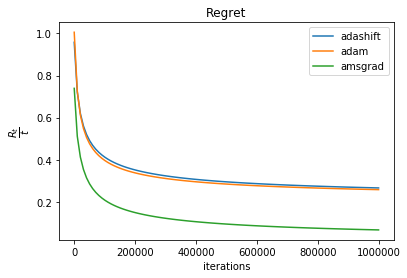

In [15]:
plt.title("Regret")
plt.plot(np.linspace(1, 1000001, 100), adashift_avg_regret_history, label='adashift')
plt.plot(np.linspace(1, 1000001, 100), avg_regret_history,label='adam')
plt.plot(np.linspace(1, 1000001, 100), amsgrad_avg_regret_history,label='amsgrad')
plt.xlabel("iterations")
plt.ylabel(r"$\dfrac{R_t}{t}$")
plt.legend()
plt.show()

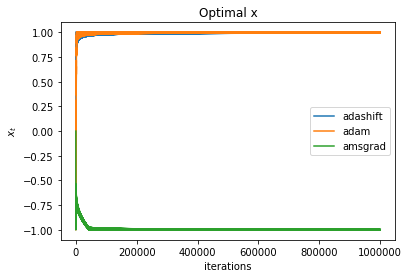

In [16]:
plt.title("Optimal x")
plt.plot(adashift_x_history, label='adashift')
plt.plot(x_history,label='adam')
plt.plot(amsgrad_x_history,label='amsgrad')
plt.legend()
plt.xlabel("iterations")
plt.ylabel(r"$x_t$")
plt.show()

Let's see on the similar task, but with stochasticity.

$\delta = 0.002$
C = 101

$f_t(x) = \begin{cases} Cx, \text{with p } =\frac{1+\delta}{C+1} \\ 
-x, otherwise \end{cases}$

Cost function is $\delta x$

In [82]:
delta = 0.02
C = 101
p = (1+delta)/(C + 1)

def stoch_f_t(x, t):
    if np.random.binomial(1,p):
        return C*x
    else:
        return -x
    

def domain_constraints(x):
    if x > 1.0:
        return x_max
    if x < -1.0:
        return x_min
    return x

def cost_f(x):
    return delta*x

In [83]:
def StochLearning(optimizer_type='Adam',learning_rate=1e-3, amsgrad=False, max_step = 1000001, betas=(0.0, 0.99)):
    x = torch.tensor([0.5], requires_grad=True)
    if optimizer_type == "Adam":
        optimizer = torch.optim.Adam([x], lr=learning_rate, betas=betas, eps=1e-8, amsgrad=amsgrad)
    else:
        optimizer = ad_opt.AdaShift([x], lr=learning_rate, betas=betas, eps=1e-8)
    regret_sum = 0
    time_steps = []
    avg_regret_history = []
    x_history = []
    loss_history = []
    print("Optimization with {}".format(optimizer_type))
    for step in range(1, max_step):
        #x = domain_constraints(x)
        x.data = domain_constraints(x).data
        loss = stoch_f_t(x, step)
    
        optimizer.zero_grad()
        loss.backward()
#         x_history.append(cost_f(x).item())
        x_history.append(x.item())
        loss_history.append(loss.item())
        time_steps.append(step)

        if step % 15000 == 0:
            print ('step : ',step, '  loss : ',loss.item(), ' x:', x.item() )
        
        optimizer.step()   
    return time_steps, loss_history, x_history

In [84]:
lr = 1e-3
time_steps, loss_history, x_history = StochLearning(learning_rate=lr,max_step=100000)

Optimization with Adam
step :  15000   loss :  -1.768214464187622  x: 1.768214464187622
step :  30000   loss :  -2.734755754470825  x: 2.734755754470825
step :  45000   loss :  -3.6636345386505127  x: 3.6636345386505127
step :  60000   loss :  -4.710565090179443  x: 4.710565090179443
step :  75000   loss :  -5.6462016105651855  x: 5.6462016105651855
step :  90000   loss :  -6.377190589904785  x: 6.377190589904785


In [85]:
adashift_time_steps, adashift_loss_history, adashift_x_history = StochLearning(learning_rate=lr, optimizer_type='Adashift',max_step=100000)

Optimization with Adashift
step :  15000   loss :  -1.5352106094360352  x: 1.5352106094360352
step :  30000   loss :  221.4011688232422  x: 2.1920907497406006
step :  45000   loss :  270.8948669433594  x: 2.6821274757385254
step :  60000   loss :  -3.746302604675293  x: 3.746302604675293
step :  75000   loss :  -4.82081413269043  x: 4.82081413269043
step :  90000   loss :  608.5982055664062  x: 6.0257248878479


In [86]:
ams_time_steps, ams_loss_history, ams_x_history = StochLearning(learning_rate=lr, amsgrad=True, max_step=100000)

Optimization with Adashift
step :  15000   loss :  -1.4298229217529297  x: 1.4298229217529297
step :  30000   loss :  -2.3199448585510254  x: 2.3199448585510254
step :  45000   loss :  -3.200026273727417  x: 3.200026273727417
step :  60000   loss :  -4.207965850830078  x: 4.207965850830078
step :  75000   loss :  -4.705874443054199  x: 4.705874443054199
step :  90000   loss :  -5.31606388092041  x: 5.31606388092041


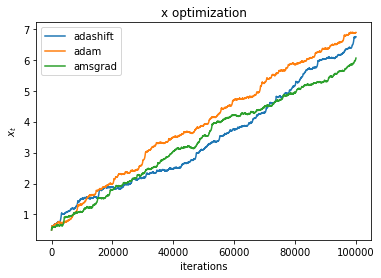

In [87]:
plt.title("x optimization")
plt.plot(adashift_x_history, label='adashift')
plt.plot(x_history,label='adam')
plt.plot(ams_x_history, label='amsgrad')
plt.legend()
plt.xlabel("iterations")
plt.ylabel(r"$x_t$")
plt.show()

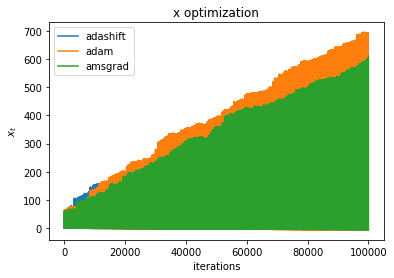

In [90]:
plt.title("x optimization")
plt.plot(adashift_loss_history, label='adashift')
plt.plot(loss_history,label='adam')
plt.plot(ams_loss_history, label='amsgrad')
plt.legend()
plt.xlabel("iterations")
plt.ylabel(r"$x_t$")
plt.show()